# Introduction 

- The categories in are available in tender_categories
- Data that is useful for categorization includes
  - 'tender_details'
  - 'tender_description' 
  - 'boq_items'
  - 'boq_details'
- After going through the features, we chose to combine the columns into a single string before feeding to the model
- We used a simple countvectorizer to make vectors based on word frequencies
- Naive Bayes was used to analyze these vectors
- Evaluation using the standard accuracy metric suggests that gave good results but when using balanced accuracy we understood that naive bayes does not perform well

## Flow of logic

### Ingesting tenders
- Reading of data into pandas
- Fixing repeated columns
- Checking for uniqueness of information
  - boq_details and boq_items
  - tender_description and tender_details
  - tender_details and boq_details
### Feature engineering
- Creating labels
  - Plotting the skew in data
  - Looking for ways to combine labels
- Dropping additional columns
- Splitting the data into train and test set
- Representing the text as vectors: Countvectorizer
  - Combining tender_details and boq_details into a single string
  - Tokenizing the string using Spacy tokenizer
    - Training vector which can transform new instances
### Model training
#### Using Naive Bayes
### Evaluation
- Evaluation is carried out using the accuracy metric
- Evaluation is carried out using the balanced accuracy metric

# Ingesting Tenders

In [1]:
import pandas as pd

In [2]:
tenders = pd.read_csv(
filepath_or_buffer='data/dataScienceAssignment/tender.csv',\
# This is the file path of the csv
# Get the column names from a header row
na_values='[]',
header=0,
)

In [3]:
tendersTh.head()

,Unnamed: 0.1,Unnamed: 0,tender_id,tender_description,tender_details,tender_category,boq_items,boq_details,boq_len
0,0,0,ad77c36d-ee5b-415a-917b-f65a81752625,Construction Of Rcc Drain With Cover Slab From...,Construction Of Rcc Drain With Cover Slab From...,Works,"[{'rowNumber': 12, 'itemDescription': 'Dismant...",['Dismantling and removing cement concrete inc...,11
1,1,1,d17ff512-0f4e-4e63-b9c0-4b4c13157f47,Day To Day Upkeeping Of Lawn And Garden At Koy...,Day To Day Upkeeping Of Lawn And Garden At Koy...,Works,"[{'rowNumber': 21, 'itemDescription': 'Shiftin...",['Shifting of Ghamlas from garden to 1 to 10 t...,29
2,2,2,d5d6a926-6dec-473c-b6f4-c195e1c334f2,"P/l Wmb G-ii, 75 Mm Thick Wet Mix Macadam And ...","P/l Wmb G-ii, 75 Mm Thick Wet Mix Macadam And ...",Works,"[{'rowNumber': 12, 'itemDescription': 'Providi...","['Providing , laying, spreading and compacting...",4
3,3,3,67bab7b5-b577-481f-a64f-f52a9e89a13f,Improvement And Biannual Maintenance To Anjang...,Improvement And Biannual Maintenance To Anjang...,Works,"[{'rowNumber': 12, 'itemDescription': 'IMPROVE...",['IMPROVEMENT AND BIANNUAL MAINTENANCE TO ANJA...,1
4,4,4,a47aeaf3-7b4d-4551-8d7e-c0415f65f411,Pre-monsoon Cleaning And Desilting Of,Pre-monsoon Cleaning And Desilting Of Exisitin...,Works,"[{'rowNumber': 18, 'itemDescription': 'GST 12%...","['GST 12%', 'PROVIDING AND OPERATING DUMPER OF...",6


## Fixing the extra index columns 

In [4]:
tenders.loc[tenders['Unnamed: 0.1']!=tenders['Unnamed: 0']]

,Unnamed: 0.1,Unnamed: 0,tender_id,tender_description,tender_details,tender_category,boq_items,boq_details,boq_len


In [5]:
tenders.loc[tenders.index!=tenders['Unnamed: 0']]

,Unnamed: 0.1,Unnamed: 0,tender_id,tender_description,tender_details,tender_category,boq_items,boq_details,boq_len


In [6]:
tenders.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

In [7]:
tenders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tender_id           100 non-null    object
 1   tender_description  100 non-null    object
 2   tender_details      100 non-null    object
 3   tender_category     91 non-null     object
 4   boq_items           72 non-null     object
 5   boq_details         69 non-null     object
 6   boq_len             100 non-null    int64 
dtypes: int64(1), object(6)
memory usage: 5.6+ KB


## BOQ items and details equivalence

In [8]:
tenders['boq_items'][0]

"[{'rowNumber': 12, 'itemDescription': 'Dismantling and removing cement concrete including stacking the useful materials for re use and removing the debries within 50 mtr lead complete as per the direction of engineer in charge.', 'quantity': 9.0, 'units': 'Cum', 'rate': 5268.6, 'amount': 585.4, '_class': 'com.ofb.core.domain.mongo.BOQ'}, {'rowNumber': 13, 'itemDescription': 'Dismantling and removing RCC including stacking the useful materials for re use and removing the debries within 50 mtr lead complete as per the direction of engineer in charge.', 'quantity': 24.0, 'units': 'Cum', 'rate': 28015.2, 'amount': 1167.3, '_class': 'com.ofb.core.domain.mongo.BOQ'}, {'rowNumber': 14, 'itemDescription': 'Earthwork excavation of foundation in all kinds of soil with all leads ,lifts,delifts,including rough dressing and levelling the bed and depositing the excavated earth away from work site and breaking the clods to maximum 5cm to 7cm in size and laying in layers not exceeding 0.30m in depth 

- Assuming that the quantity, units, rate, amount and '\_class' quantities do not affect the category of the item
- The only important information is the 'itemDescription'
- Observing that the column boq_details also contains similar information

Checking for equivalence of values in 'boq_items' & 'boq_details'

In [9]:
from ast import literal_eval

In [10]:
def boq_items_conv(rowitem):
    """Function to filter the items description from boq_items and add to list
    """
    boq_details = [] # List contain item descriptions
    if rowitem != '[]':
        boqitemslist = literal_eval(rowitem) # Literal evaluation of the bytes to convert to python list
        for item in boqitemslist:
            boq_details.append(item['itemDescription']) # Adding descriptions to the list
    return boq_details

In [11]:
boq_items_conv(tenders['boq_items'][0])

['Dismantling and removing cement concrete including stacking the useful materials for re use and removing the debries within 50 mtr lead complete as per the direction of engineer in charge.',
 'Dismantling and removing RCC including stacking the useful materials for re use and removing the debries within 50 mtr lead complete as per the direction of engineer in charge.',
 'Earthwork excavation of foundation in all kinds of soil with all leads ,lifts,delifts,including rough dressing and levelling the bed and depositing the excavated earth away from work site and breaking the clods to maximum 5cm to 7cm in size and laying in layers not exceeding 0.30m in depth etc complete as per direction of the Engineer-in-charge.',
 'Filling foundation and plinth with sand well watered and rammed with cost , conveyance , royalty ,taxes,labour , T & P , cess etc complete as per direction of the Engineer-in-charge.',
 'Cement Concrete  (1:3:6) with 40mm size  hard granite crusher broken metal including 

In [12]:
def boq_details_conv(rowitem):
    """ Function to convert the bytes in boq_details to python list
    """
    if rowitem != '[]':
        test = literal_eval(rowitem)
        return test

In [13]:
tenders['boq_details'][80:90]

80    ['Supplying and fixing Moulded Case Circuit Br...
81                                                  NaN
82                                                  NaN
83                                                  NaN
84    ['Supplying of 1.1 KV LT UG cable XLPE or Heat...
85                                                  NaN
86    ['Supplying ......... amps rated 3phase with n...
87    ['Supply and installation of ……. Inverter(home...
88    ['Fabricating supplying and mounting MS box ma...
89    ['Scraping of grass and other growth around th...
Name: boq_details, dtype: object

In [14]:
boq_details_conv(tenders['boq_details'][0])

['Dismantling and removing cement concrete including stacking the useful materials for re use and removing the debries within 50 mtr lead complete as per the direction of engineer in charge.',
 'Dismantling and removing RCC including stacking the useful materials for re use and removing the debries within 50 mtr lead complete as per the direction of engineer in charge.',
 'Earthwork excavation of foundation in all kinds of soil with all leads ,lifts,delifts,including rough dressing and levelling the bed and depositing the excavated earth away from work site and breaking the clods to maximum 5cm to 7cm in size and laying in layers not exceeding 0.30m in depth etc complete as per direction of the Engineer-in-charge.',
 'Filling foundation and plinth with sand well watered and rammed with cost , conveyance , royalty ,taxes,labour , T & P , cess etc complete as per direction of the Engineer-in-charge.',
 'Cement Concrete  (1:3:6) with 40mm size  hard granite crusher broken metal including 

Listing out rows in which the lists are different

Since there are no such rows. We will drop the 'boq_items'

In [15]:
tenders.drop(columns=['boq_items'], inplace=True)

In [16]:
tenders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tender_id           100 non-null    object
 1   tender_description  100 non-null    object
 2   tender_details      100 non-null    object
 3   tender_category     91 non-null     object
 4   boq_details         69 non-null     object
 5   boq_len             100 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 4.8+ KB


## tender_description and tender_details equivalence

It appears that tender_description and tender_details are also very similar.
Printing the cases, where it is different.

In [17]:
tenders.loc[tenders['tender_description']!=tenders['tender_details']][['tender_description','tender_details']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 1 to 70
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tender_description  20 non-null     object
 1   tender_details      20 non-null     object
dtypes: object(2)
memory usage: 480.0+ bytes


In [18]:
tenders.loc[tenders['tender_description']!=tenders['tender_details']][['tender_description','tender_details']].values

array([['Day To Day Upkeeping Of Lawn And Garden At Koyla Vihar Colony, Indora Complex And Admin Building, Vip Guest House , Annex Building Of Wcl, Hq, Nagpur. ( For 01 Year )',
        'Day To Day Upkeeping Of Lawn And Garden At Koyla Vihar Colony, Indora Complex And Admin Building, Vip Guest House , Annex Building Of Wcl, Hq, Nagpur.( For 01 Year )'],
       ['Pre-monsoon Cleaning And Desilting Of',
        'Pre-monsoon Cleaning And Desilting Of Exisiting Nallas In Ward Office No 4 Area.'],
       ['Design, Build And Operate Contract For Morbi Maliya Augumentation Regional Water Supply Scheme',
        'Design, Build And Operate Contract For Morbi Maliya Augumentation Regional Water Supply Scheme. \ninstrument Of Tender Fee & Emd Shall Be Submitted In Electronic Format Only Through Online (by Scanning While Uploading The Bid). This Submission Shall Mean That Tender Fee And Emd Are Received For Purpose Of Opening The Bid. Accordingly, Offer Of Only Those Shall Be Open Whose Tender Fee

- It is observed that in the 20 cases, tender_description and tender_details don't match
- In these cases, tender_details has a copy of the information in tender_description and a few more details

In [19]:
tenders.drop(columns=['tender_description'], inplace=True)

## tender_details and boq_details

In [20]:
tenders[['tender_details', 'boq_details']][:5].values

array([['Construction Of Rcc Drain With Cover Slab From Plot No 87/a Manisha Enclave To Plot No 24/2224 At Saswath Vihar In Ward No 6',
        "['Dismantling and removing cement concrete including stacking the useful materials for re use and removing the debries within 50 mtr lead complete as per the direction of engineer in charge.', 'Dismantling and removing RCC including stacking the useful materials for re use and removing the debries within 50 mtr lead complete as per the direction of engineer in charge.', 'Earthwork excavation of foundation in all kinds of soil with all leads ,lifts,delifts,including rough dressing and levelling the bed and depositing the excavated earth away from work site and breaking the clods to maximum 5cm to 7cm in size and laying in layers not exceeding 0.30m in depth etc complete as per direction of the Engineer-in-charge.', 'Filling foundation and plinth with sand well watered and rammed with cost , conveyance , royalty ,taxes,labour , T & P , cess etc 

- It appears that the data in both these items are different
- One might want to evaluate the usefulness of joining these two items to make a single column
- For the moment, I am going to fill all the NAN values in boq_details with the values in tender_details

# Feature Engineering

## Labels

Converting the tender_category column a form that can be fed to models

In [21]:
tenders['tender_category'].unique()

array(['Works', 'PERCENTAGE', 'ITEM RATE', nan, 'Services', 'Goods',
       'WORKS', 'SERVICES', 'GOODS'], dtype=object)

The 'nan' objects are not useful and we will drop these rows from further analysis

In [22]:
tenders.loc[tenders['tender_category'].isna()].count()

tender_id          9
tender_details     9
tender_category    0
boq_details        9
boq_len            9
dtype: int64

This amounts to ~10% of the total data available

In [23]:
tenders.dropna(subset=['tender_category'], inplace=True)

Creating a labels column with normalized categories

In [24]:
tenders['labels'] = tenders['tender_category'].map({'Works':1, 'WORKS':1, 'Services': 2, 'SERVICES': 2, 'Goods': 3, 'GOODS': 3, 'ITEM RATE': 4, 'PERCENTAGE': 5})

In [25]:
tenders.drop(columns=['tender_category'], inplace=True)

Checking the spread of the data

In [26]:
import matplotlib.pyplot as plt

<AxesSubplot: >

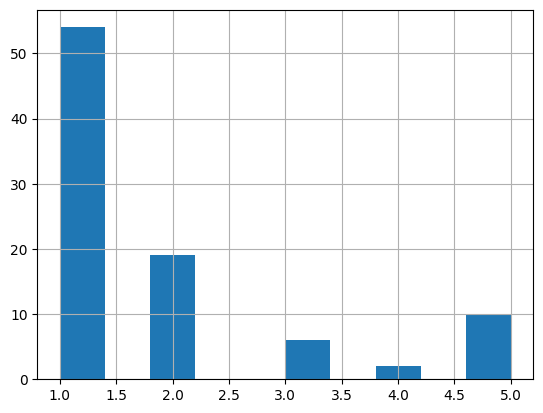

In [27]:
tenders['labels'].hist()

Note the skew in the data towards 'Work' and 'Services' categories

In [28]:
tenders.loc[tenders['labels']==4]['boq_details'].values

array(["['Supply, Installation & Commissioning of Milk Homogenizer, Capacity 10KLPH  for Sitamarhi Dairy, Sitamarhi, Bihar']",
       '["Open Tender Enquiry (RFP) To Select a Service Provider for Development, Implementation, Operational Training & Support of Unified Management Information System \'Unified-MIS\'."]'],
      dtype=object)

Checking to see if 'ITEM RATE' can be absorbed in the other categories

In [29]:
tenders.loc[tenders['labels']==5]['boq_details'].values

array(["['Removal of Jalkumbhi and Aquatic grass, Daldal &Sewage material  of Badshahi Nala in between 0.00 km to 16.50 km']",
       "['BED CLEARNCE OF PARSA BARMUTTA NALA UNDER PUNPUN FLOOD PROTECTION SUB DIVISION PUNPUN PATNA']",
       "['Removal of Jalkumbhi and Aquatic grass, Daldal & Sewage  material of Badshahi Nala  between 16.50 KM TO 30.13 KM']",
       "['Removal of Jalkumbhi and Aquatic grass, Daldal & Sewage  material of Pahari Sewerage Nala in between Ch- 0 & 215 (6.65km)and KhanuaNala in between  Ch- 0 &171.25 (5.22km)']",
       "['Removal of Jalkumbhi and Aquatic grass, Daldal & Sewage  material of Parsa Barmutta Nala in a length of 6.60 km']",
       "['Request for Proposal (RFP) for Development of Mushahari Ghat in Bhagalpur including DLP with maintenance for two (2) years under Smart City Mission on Percentage Rate basis.']",
       "['Repair & Painting work of Hostel No. 01 of Government Ambedkar Girls Residential School (+2) Dighi Hajipur for the Year 2022-23']",

Checking to see if 'PERCENTAGE' can be absorbed in the other categories

## Features

In [30]:
tenders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 0 to 99
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tender_id       91 non-null     object
 1   tender_details  91 non-null     object
 2   boq_details     60 non-null     object
 3   boq_len         91 non-null     int64 
 4   labels          91 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 4.3+ KB


- tender_id is a unique number with no connection to the category
- boq_len also has no connection with the category

In [31]:
tenders.drop(columns=['tender_id', 'boq_len'], inplace=True)

Ideally I would want to convert the text from tender_details and boq_details to vectors too but we intend to try out different ways of vectorizing them and will postpone to the sections below

## Split

In [32]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(tenders, test_size=0.2, random_state=1)

## Representation: Bag of words

### Combining columns to create a single feature string

In [33]:
train_set['boq_details'].fillna('[]',inplace=True)

In [34]:
test_set['boq_details'].fillna('[]',inplace=True)

Combining the line items in boq_details into a single string

In [35]:
def boq_details_concat(rowitem):
    """ Function to convert the bytes in boq_details to python list
    """
    if rowitem is not None:
        test = literal_eval(rowitem)
        if test is not None:
            return ' '.join(test)
    else:
        return ''

In [36]:
combined_features = train_set['tender_details'].values + train_set['boq_details'].map(boq_details_concat).values

In [37]:
combined_features_test = test_set['tender_details'].values + test_set['boq_details'].map(boq_details_concat).values

### Creating count vectors

In [41]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [42]:
def spacy_tokenizer(document):
    tokens = nlp(document)
    tokens = [token.lemma_.lower() for token in tokens if (
        token.is_stop == False and \
        token.is_punct == False and \
        token.lemma_.strip()!= '')]
    return tokens

In [43]:
from sklearn.feature_extraction.text import CountVectorizer
vector = CountVectorizer(input = 'content', tokenizer = spacy_tokenizer)

In [44]:
train_features_td = vector.fit_transform(combined_features)

/home/sumeetkd/.pyenv/versions/DS/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [45]:
test_features_td = vector.transform(combined_features_test)

In [46]:
train_features_td

<72x2650 sparse matrix of type '<class 'numpy.int64'>'
	with 7353 stored elements in Compressed Sparse Row format>

In [47]:
test_features_td

<19x2650 sparse matrix of type '<class 'numpy.int64'>'
	with 2154 stored elements in Compressed Sparse Row format>

# Model selection and prediction

- There could be a relation between the first few words of tender_details and the label. We will try to capture the first few words of the description and use that as features

# Model: Naive Bayes

In [48]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

In [51]:
tenders['labels'][1:8].values

/tmp/ipykernel_1899753/812729284.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  tenders['labels'][1:8].values


array([1, 1, 1, 1, 5, 5, 5])

In [52]:
nb.fit(train_features_td,train_set['labels'])

MultinomialNB()

In [53]:
nb.predict(train_features_td[0])

array([2])

In [54]:
train_set['labels'][0]

1

# Evaluation

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay

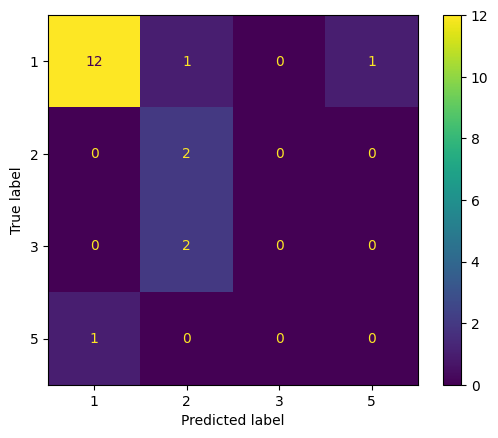

In [56]:
ConfusionMatrixDisplay.from_predictions(test_set['labels'],nb.predict(test_features_td))

Evaluation of accuracy could be done using the standard accuracy metric 

In [57]:
from sklearn.metrics import accuracy_score

In [59]:
accuracy_score(test_set['labels'],nb.predict(test_features_td))

0.7368421052631579

Being greater than 70%, this seems like an okay result. 

However, we have seen that the other classes are not doing quite well.
A better metric that is able to capture the effectiveness to classify in imbalanced classes is the balanced accuracy

In [61]:
from sklearn.metrics import balanced_accuracy_score

In [62]:
balanced_accuracy_score(test_set['labels'],nb.predict(test_features_td))

0.4642857142857143

With balanced accuracy, we can see that we the current model is not doing well and we should be exploring other models